In [2]:
# ==========================================
# Data Loading & Cleaning
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Baca dataset
df = pd.read_csv("water_potability.csv")

print("Ukuran dataset awal:", df.shape)
display(df.head())

# Cek missing values
print("\nJumlah missing value tiap kolom:")
print(df.isnull().sum())

# Isi missing value dengan median (lebih stabil daripada mean)
df = df.fillna(df.median())

# Hapus data duplikat
df = df.drop_duplicates()

# Hapus data pH yang tidak masuk akal (harus 0–14)
df = df[(df['ph'] >= 0) & (df['ph'] <= 14)]

print("\nUkuran dataset setelah cleaning:", df.shape)


Ukuran dataset awal: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



Jumlah missing value tiap kolom:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Ukuran dataset setelah cleaning: (3276, 10)


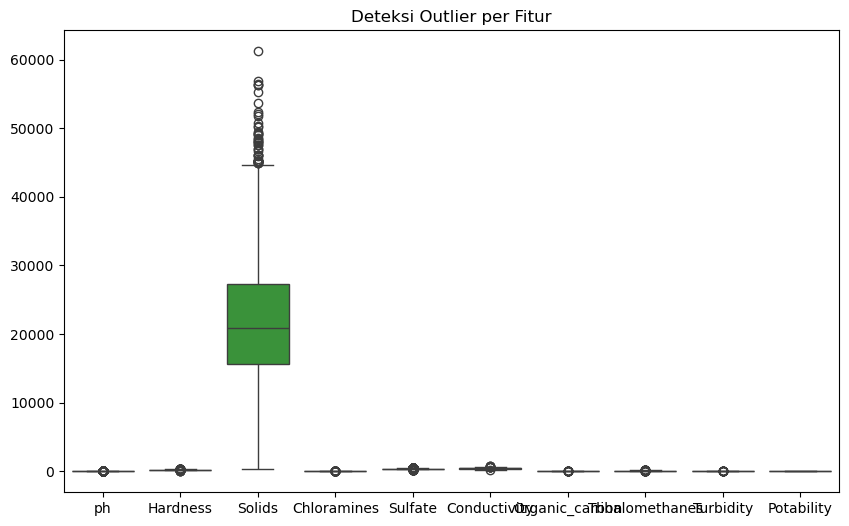

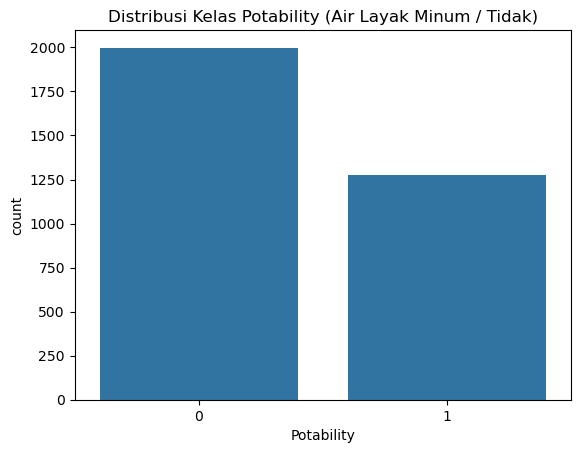

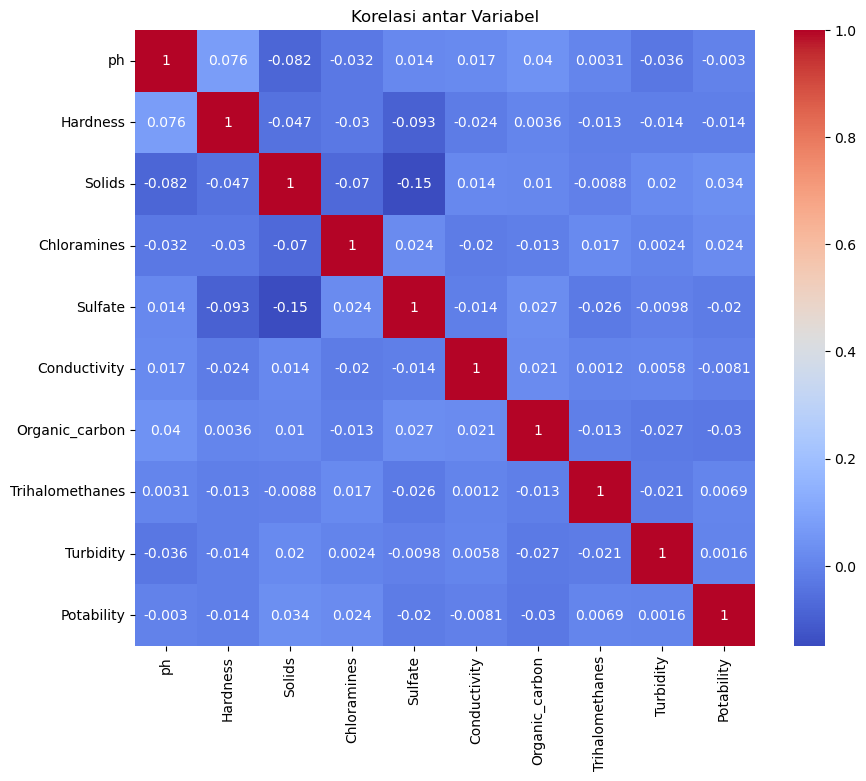

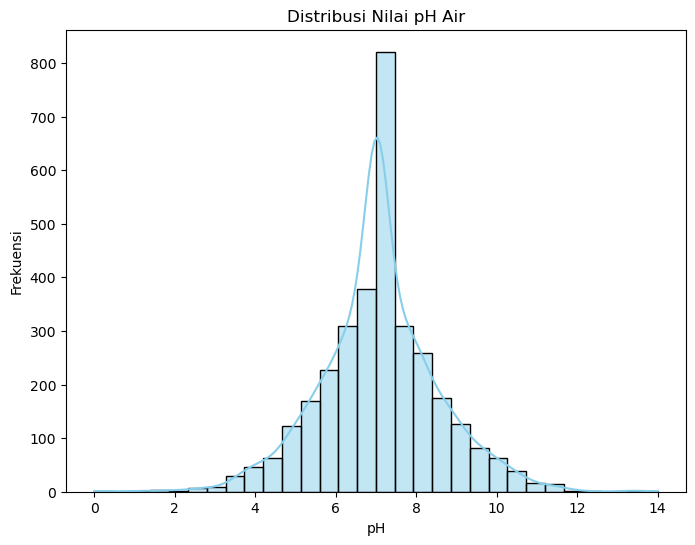

In [4]:
# ==========================================
# Exploratory Data Analysis (EDA)
# ==========================================

# Boxplot untuk deteksi outlier
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.title("Deteksi Outlier per Fitur")
plt.show()

# Distribusi label Potability
sns.countplot(x='Potability', data=df)
plt.title("Distribusi Kelas Potability (Air Layak Minum / Tidak)")
plt.show()

# Korelasi antar variabel
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Variabel")
plt.show()

# Distribusi pH air
plt.figure(figsize=(8,6))
sns.histplot(df['ph'], kde=True, bins=30, color='skyblue')
plt.title("Distribusi Nilai pH Air")
plt.xlabel("pH")
plt.ylabel("Frekuensi")
plt.show()


In [6]:
# ==========================================
# Data Preprocessing
# ==========================================
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['Potability'])
y = df['Potability']

# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Konversi kembali ke DataFrame agar mudah dibaca
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Data setelah normalisasi:")
display(X_scaled.head())


Data setelah normalisasi:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-0.025474,0.259195,-0.139471,0.112415,0.965957,1.708954,-1.180651,1.305434,-1.286298
1,-2.284717,-2.036414,-0.385987,-0.307694,-0.014799,2.062575,0.270597,-0.639186,0.684218
2,0.697319,0.847665,-0.240047,1.360594,-0.014799,-0.094032,0.781117,0.000800,-1.167365
3,0.845393,0.547651,0.000493,0.592008,0.644130,-0.778830,1.255134,2.152154,0.848412
4,1.372982,-0.464429,-0.460249,-0.363698,-0.649522,-0.343939,-0.824357,-2.182297,0.138786



Hasil akhir dengan kolom WQI:


,ph,Hardness,Solids,WQI,WQI_category
0,7.036752,204.890455,20791.318981,79.606391,Very Poor
1,3.716080,129.422921,18630.057858,75.314724,Very Poor
2,8.099124,224.236259,19909.541732,86.294241,Very Poor
3,8.316766,214.373394,22018.417441,92.375185,Very Poor
4,9.092223,181.101509,17978.986339,84.539184,Very Poor


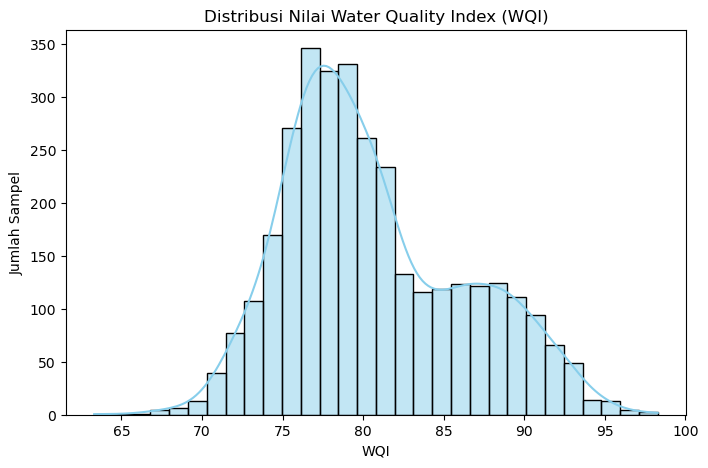

In [8]:
# ==========================================
# Feature Engineering: Water Quality Index (WQI)
# ==========================================

# Parameter dan bobot berdasarkan standar WHO
params = {
    'ph': {'Vstd': 8.5, 'Videal': 7.0, 'Wi': 0.11},
    'Hardness': {'Vstd': 300, 'Videal': 0, 'Wi': 0.10},
    'Solids': {'Vstd': 1000, 'Videal': 0, 'Wi': 0.10},
    'Chloramines': {'Vstd': 4, 'Videal': 0, 'Wi': 0.10},
    'Sulfate': {'Vstd': 400, 'Videal': 0, 'Wi': 0.10},
    'Conductivity': {'Vstd': 400, 'Videal': 0, 'Wi': 0.10},
    'Organic_carbon': {'Vstd': 4, 'Videal': 0, 'Wi': 0.10},
    'Trihalomethanes': {'Vstd': 80, 'Videal': 0, 'Wi': 0.10},
    'Turbidity': {'Vstd': 5, 'Videal': 0, 'Wi': 0.09}
}

# Hitung Qi dan WiQi untuk tiap parameter
for p in params:
    Vi = df[p]
    Vstd = params[p]['Vstd']
    Videal = params[p]['Videal']
    Wi = params[p]['Wi']

    df[f'Qi_{p}'] = np.clip(((Vi - Videal) / (Vstd - Videal)) * 100, 0, 100)
    df[f'WiQi_{p}'] = df[f'Qi_{p}'] * Wi

# Hitung total WQI
df['WQI'] = df[[f'WiQi_{p}' for p in params]].sum(axis=1) / sum(params[p]['Wi'] for p in params)

# Fungsi untuk klasifikasi WQI
def classify_wqi(value):
    if value <= 25:
        return "Excellent"
    elif value <= 50:
        return "Good"
    elif value <= 75:
        return "Poor"
    elif value <= 100:
        return "Very Poor"
    else:
        return "Unsuitable"

df['WQI_category'] = df['WQI'].apply(classify_wqi)

# Lihat hasil WQI
print("\nHasil akhir dengan kolom WQI:")
display(df[['ph', 'Hardness', 'Solids', 'WQI', 'WQI_category']].head())

# Visualisasi distribusi WQI
plt.figure(figsize=(8,5))
sns.histplot(df['WQI'], bins=30, kde=True, color='skyblue')
plt.title("Distribusi Nilai Water Quality Index (WQI)")
plt.xlabel("WQI")
plt.ylabel("Jumlah Sampel")
plt.show()


In [14]:
# ==========================================
# Feature Selection
# ==========================================

from sklearn.model_selection import train_test_split

# Pilih fitur input (X) dan target (y)
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate',
            'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'WQI'

X = df[features]
y = df[target]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Cek hasil akhir
print("Jumlah data setelah preprocessing:", df.shape)
print("Jumlah data train:", X_train.shape[0])
print("Jumlah data test:", X_test.shape[0])
print("\nContoh data hasil scaling:\n", X_train[:5])

Jumlah data setelah preprocessing: (3276, 30)
Jumlah data train: 2620
Jumlah data test: 656

Contoh data hasil scaling:
 [[-0.30655542  0.20260677 -0.55283024 -0.67768927 -0.60550871 -0.19751914
   0.4926538  -0.08791786 -1.3477761 ]
 [-0.26499499 -0.07691512  1.38505418  1.74009477  0.30236709  0.88921358
  -1.65259384  0.0159742   0.08186168]
 [-0.16201594  0.28283788 -0.42120077 -0.25866276 -0.98984022  0.84491622
  -0.1439227   0.2731399   1.26331981]
 [-0.02547355 -0.39181013 -1.06511988  1.6776965  -0.38014425  0.69593754
  -0.29484543 -1.24014625 -0.9309256 ]
 [-0.45406762 -0.41017382 -0.47483953  0.21510727 -0.03103722 -0.33937357
   0.91201907 -0.14823117  0.77817591]]


In [16]:
# Simpan hasil preprocessing agar bisa digunakan di modelling
df.to_csv("water_quality_cleaned.csv", index=False)
print("✅ File 'water_quality_cleaned.csv' berhasil disimpan.")


✅ File 'water_quality_cleaned.csv' berhasil disimpan.
